# Graph Neural Network on simulated data.

In [11]:
from torch_geometric.utils.convert import from_networkx
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.impute import SimpleImputer, KNNImputer
import networkx as nx
import seaborn as sns
import json
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader
import pickle
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [12]:
# load the graph with pickle

with open('../pickle/multiple/depnod_volume_06.pkl', 'rb') as f:
    G = pickle.load(f)

# print the first 5 nodes
print("First 5 nodes:", list(G.nodes(data=True))[:5])

First 5 nodes: [('1001', {'id': '1001', 'x': 461000.65616613504, 'y': 1351690.2559001052, 'depth': [1.12051, 1.12051, 1.12051, 1.1227, 1.15869, 1.18372, 1.21813, 1.2422, 1.26298, 1.43201, 2.6566, 2.88013, 2.92085], 'volume': [0.02051, 0.02051, 0.02051, 0.0227, 0.05869, 0.08372, 0.11813, 0.1422, 0.16298, 0.33201, 1.5566, 8.11093, 15.6868]}), ('1002', {'id': '1002', 'x': 460883.5301818835, 'y': 1351714.5341153282, 'depth': [1.04101, 1.04101, 1.04101, 1.0465, 1.08296, 1.12225, 1.17279, 1.20237, 1.22892, 1.41562, 2.63853, 2.87193, 2.91114], 'volume': [0.02101, 0.02101, 0.02101, 0.0265, 0.06296, 0.10225, 0.15279, 0.18237, 0.20892, 0.39562, 1.61853, 4.87685, 9.98838]}), ('1003', {'id': '1003', 'x': 460754.625982409, 'y': 1351744.3241415746, 'depth': [0.91088, 0.91088, 0.91088, 0.91596, 0.94149, 0.98417, 1.04179, 1.08982, 1.16149, 1.36994, 2.59135, 2.85183, 2.89089], 'volume': [0.02088, 0.02088, 0.02088, 0.02596, 0.05149, 0.09417, 0.15179, 0.19982, 0.27149, 0.47994, 1.70135, 2.0361, 2.99622]}

In [13]:
raw_nodes = list(G.nodes(data=True))
raw_edges = list(G.edges(data=True))

# 2. Create numerical mappings for node IDs
node_id_to_idx = {node[0]: idx for idx, node in enumerate(raw_nodes)}

# 3. Prepare node features (x,y coordinates) and targets (depth measures)
node_features = []
depth_measures = []

for node_id, attrs in raw_nodes:
    # Normalize coordinates (important for GNN performance)
    node_features.append([attrs['x'], attrs['y']])
    depth_measures.append(attrs['depth'])

# Convert to tensors
node_features = torch.tensor(node_features, dtype=torch.float)
depth_measures = torch.tensor(depth_measures, dtype=torch.float)

# 4. Prepare edge index (convert node IDs to numerical indices)
edge_index = []
for src, dst, _ in raw_edges:
    edge_index.append([node_id_to_idx[src], node_id_to_idx[dst]])

# Convert to edge index format expected by PyG (shape [2, num_edges])
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# 5. Normalize features (crucial for good performance)
def normalize_tensor(tensor):
    mean = tensor.mean(dim=0)
    std = tensor.std(dim=0)
    return (tensor - mean) / (std + 1e-8)

node_features = normalize_tensor(node_features)
depth_measures = normalize_tensor(depth_measures)

# 6. Create PyG Data object
data = Data(x=node_features, edge_index=edge_index, y=depth_measures)

Baseline MSE: 0.9989, Baseline MAE: 0.7999
Epoch: 0, Loss: 1.0096, Val Loss: 0.9573, MAE Loss: 0.7793
Epoch: 20, Loss: 0.5987, Val Loss: 0.6289, MAE Loss: 0.5911
Epoch: 40, Loss: 0.5275, Val Loss: 0.5350, MAE Loss: 0.5464
Epoch: 60, Loss: 0.4554, Val Loss: 0.4628, MAE Loss: 0.5045
Epoch: 80, Loss: 0.4335, Val Loss: 0.4338, MAE Loss: 0.4911
Epoch: 100, Loss: 0.4166, Val Loss: 0.4175, MAE Loss: 0.4826
Epoch: 120, Loss: 0.4075, Val Loss: 0.4086, MAE Loss: 0.4738
Epoch: 140, Loss: 0.4050, Val Loss: 0.3988, MAE Loss: 0.4720
Epoch: 160, Loss: 0.3977, Val Loss: 0.3926, MAE Loss: 0.4665
Epoch: 180, Loss: 0.3906, Val Loss: 0.3950, MAE Loss: 0.4671
Epoch: 200, Loss: 0.3848, Val Loss: 0.3919, MAE Loss: 0.4674


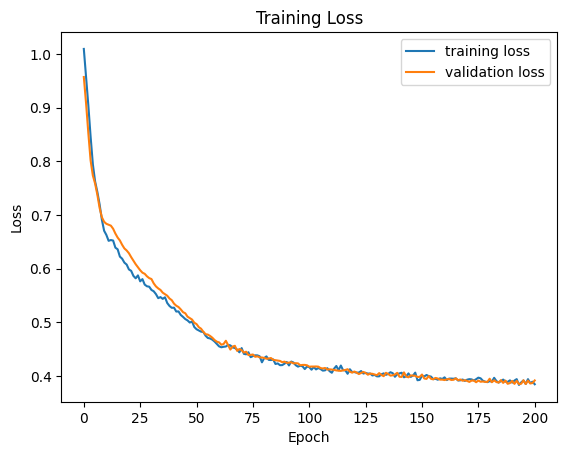

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# 2. Define the GNN model
class DepthGNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(2, 64)  # Input: 2D coordinates
        self.conv2 = GCNConv(64, 64)
        self.fc = nn.Linear(64, 13)  # Output: 13 depth values
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        return self.fc(x)

# 3. Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DepthGNN().to(device)
data = data.to(device)

# Split the data into training and validation sets

num_nodes = data.num_nodes
train_size = int(0.8 * num_nodes)
perm = torch.randperm(num_nodes)
train_mask = perm[:train_size]
val_mask = perm[train_size:]

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()
mae_criterion = nn.L1Loss()

# 4. Predict baseline
baseline_pred = torch.zeros_like(data.y[val_mask])  # predicts 0 for all validation nodes

val_targets = data.y[val_mask]

baseline_mse = F.mse_loss(baseline_pred, val_targets).item()
baseline_mae = F.l1_loss(baseline_pred, val_targets).item()

print(f"Baseline MSE: {baseline_mse:.4f}, Baseline MAE: {baseline_mae:.4f}")

# 5. Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item(), out

def validate():
    model.eval()
    with torch.no_grad():
        out = model(data)
        val_loss = criterion(out[val_mask], data.y[val_mask])
        mae_loss = mae_criterion(out[val_mask], data.y[val_mask])

    return val_loss.item(), mae_loss.item(), out

num_epochs = 201
losses = []
val_losses = []
for epoch in range(num_epochs):
    loss, outi = train()
    val_loss, mae_loss, out = validate()
    if epoch % 20 == 0:
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, MAE Loss: {mae_loss:.4f}')
    losses.append(loss)
    val_losses.append(val_loss)


# num_epochs = 201
# losses = []
# val_losses = []

# for epoch in range(num_epochs):
#     # New 80/20 split every epoch


#     # Train
#     loss = train()

#     # Validate
#     val_loss, mae_loss = validate()

#     if epoch % 20 == 0:
#         print(f'Epoch: {epoch}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, MAE Loss: {mae_loss:.4f}')
#         num_nodes = data.num_nodes
#         train_size = int(0.8 * num_nodes)
#         perm = torch.randperm(num_nodes)
#         train_mask = perm[:train_size]
#         val_mask = perm[train_size:]
    
#     losses.append(loss)
#     val_losses.append(val_loss)

plt.plot(losses, label = 'training loss')
plt.plot(val_losses, label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
# plt.savefig('../img/neural_network/training_loss_10.png')
plt.show()



In [15]:
# 6. Make predictions
model.eval()
with torch.no_grad():
    predictions = model(data)
    targets = data.y
    print("Predictions shape:", predictions.shape)  # Should be [num_nodes, 13]
    print("Predictions:", predictions)
    print("Targets shape:", data.y.shape)  # Should be [num_nodes, 13]
    print("Targets:", data.y)
    node_errors = F.mse_loss(predictions, targets, reduction='none')  # Shape: [num_nodes, 13]
    node_errors = node_errors.mean(dim=1)  # Shape: [num_nodes]

    print("Node-wise MSE errors:", node_errors)
    print("Node-wise MSE errors shape:", node_errors.shape)  # Should be [num_nodes]
    print("Original depth measures shape:", depth_measures.shape)  # Should be [num_nodes]

Predictions shape: torch.Size([6193, 13])
Predictions: tensor([[-0.5394, -0.5348, -0.5336,  ..., -0.4588, -0.5877, -0.7966],
        [-0.6217, -0.6141, -0.6111,  ..., -0.5376, -0.6452, -0.8880],
        [-0.5249, -0.5209, -0.5196,  ..., -0.4363, -0.5419, -0.7486],
        ...,
        [ 0.9089,  0.8829,  0.8938,  ...,  1.0918,  1.1104,  1.1032],
        [ 0.8586,  0.8473,  0.8511,  ...,  1.0760,  1.1244,  1.0806],
        [ 0.8235,  0.8140,  0.8148,  ...,  1.0247,  1.0833,  1.0568]],
       device='cuda:0')
Targets shape: torch.Size([6193, 13])
Targets: tensor([[-0.0646, -0.0685, -0.0758,  ...,  1.4216,  1.2189,  0.9125],
        [-0.1658, -0.1697, -0.1770,  ...,  1.3991,  1.2096,  0.9020],
        [-0.3316, -0.3355, -0.3427,  ...,  1.3405,  1.1868,  0.8801],
        ...,
        [ 1.2354,  1.2302,  1.2227,  ...,  0.9839,  0.6383,  0.3992],
        [ 1.4270,  1.4228,  1.4156,  ...,  1.0060,  0.6416,  0.4000],
        [ 0.0508,  0.0458,  0.0383,  ..., -0.2067, -0.4093, -0.5352]],
      

In [16]:
# Let's add the errors to the original graph
for i, node in enumerate(G.nodes(data=True)):
    node_id = node[0]
    G.nodes[node_id]['error'] = node_errors[i].item()

# Print the first 5 nodes with their errors
print("First 5 nodes with their errors:")   
for node_id, attrs in list(G.nodes(data=True))[:5]:
    print(f"Node ID: {node_id}, Error: {attrs['error']:.4f}")

First 5 nodes with their errors:
Node ID: 1001, Error: 0.9543
Node ID: 1002, Error: 1.0154
Node ID: 1003, Error: 0.7449
Node ID: 1004, Error: 0.7367
Node ID: 1005, Error: 0.6484


The length of the graph is 6193


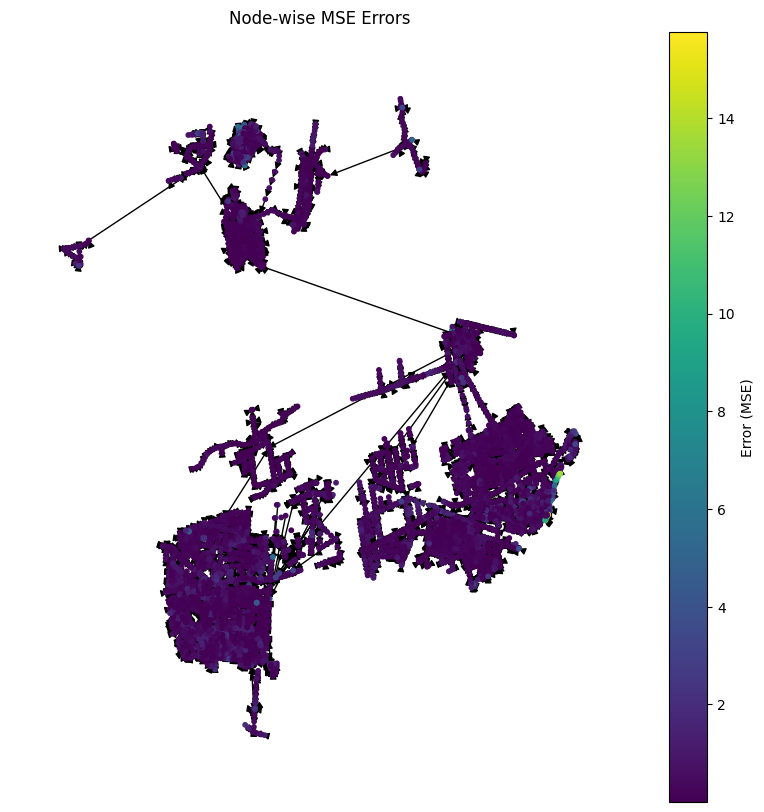

In [17]:
print(f'The length of the graph is {len(G.nodes())}')

# Extract error values
error_dict = nx.get_node_attributes(G, 'error')

# Filter nodes that have both position and error
pos = {
    node: (attrs["x"], attrs["y"])
    for node, attrs in G.nodes(data=True)
    if node in error_dict and "x" in attrs and "y" in attrs
}

nodes_to_draw = list(pos.keys())
errors = np.array([error_dict[node] for node in nodes_to_draw])

# Normalize and colormap
norm = plt.Normalize(errors.min(), errors.max())
cmap = plt.cm.viridis
normalized_colors = cmap(norm(errors))

# Create plot
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(
    G.subgraph(nodes_to_draw),
    pos=pos,
    node_size=10,
    node_color=normalized_colors,
    with_labels=False,
    ax=ax
)

# Add colorbar
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Error (MSE)')

# plt.savefig('../img/neural_network/depth_error_02.png', dpi=300)
plt.title('Node-wise MSE Errors')
plt.show()

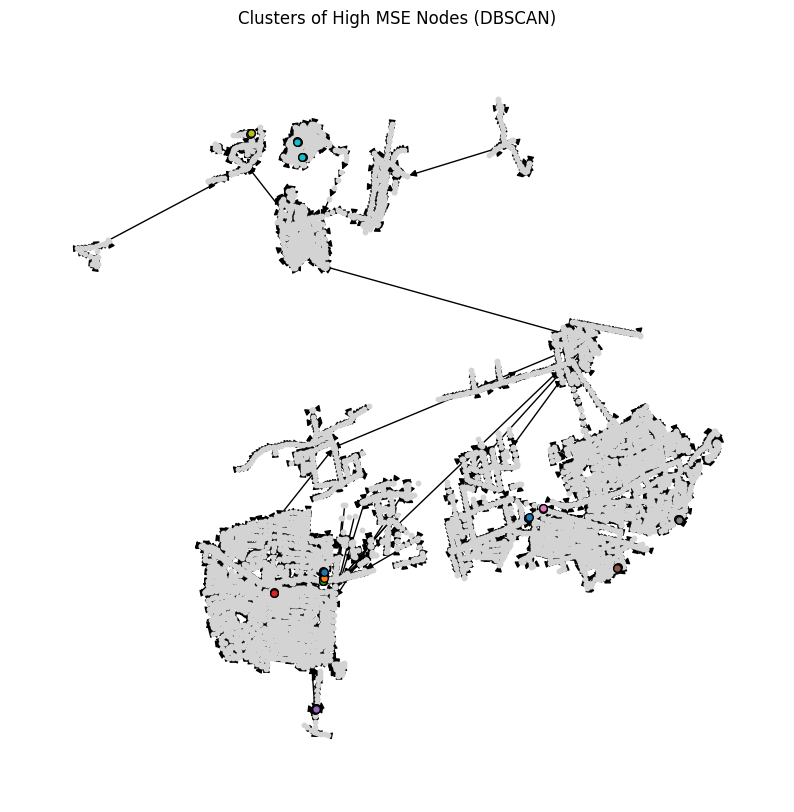

In [22]:
from sklearn.cluster import DBSCAN

# Step 1: Extract high-error nodes
threshold = 1.0
high_error_nodes = [
    node for node in G.nodes()
    if 'error' in G.nodes[node] and G.nodes[node]['error'] > threshold
]

# Step 2: Get their spatial positions
high_error_coords = np.array([
    (G.nodes[node]['x'], G.nodes[node]['y']) for node in high_error_nodes
])

# Step 3: Apply DBSCAN clustering
clustering = DBSCAN(eps=50, min_samples=3).fit(high_error_coords)
labels = clustering.labels_

# Step 4: Visualize the clusters
fig, ax = plt.subplots(figsize=(10, 10))
colors = plt.cm.tab10(labels / labels.max() if labels.max() > 0 else 0)

# Plot original graph in gray
nx.draw(G, pos=pos, node_color='lightgray', node_size=10, with_labels=False, ax=ax)

# Overlay high-error clustered nodes
for i, node in enumerate(high_error_nodes):
    x, y = G.nodes[node]['x'], G.nodes[node]['y']
    cluster_label = labels[i]
    if cluster_label != -1:  # -1 means noise
        ax.scatter(x, y, color=colors[i], s=30, edgecolor='black', zorder=5)
        None

plt.title("Clusters of High MSE Nodes (DBSCAN)")
plt.xlabel("X")
plt.ylabel("Y")
# plt.savefig('../img/neural_network/dbscan_high_error_02.png')
plt.show()

In [19]:
from collections import defaultdict

# Initialize a dictionary to hold node IDs per cluster
clusters = defaultdict(set)

# Iterate over nodes and their corresponding cluster labels
for node, label in zip(high_error_nodes, labels):
    if label != -1:  # Ignore noise
        clusters[label].add(node)

# Convert to a list of sets
clustered_node_sets = list(clusters.values())

# Optionally print or inspect
for i, cluster in enumerate(clustered_node_sets):
    print(f"Cluster {i} ({len(cluster)} nodes): {sorted(cluster)[:5]}...")


Cluster 0 (3 nodes): ['1151', '2198', '2199']...
Cluster 1 (3 nodes): ['122011', '122014', '122025']...
Cluster 2 (3 nodes): ['122015', '122018', '122023']...
Cluster 3 (3 nodes): ['122020', '122020C2', '122020_klep']...
Cluster 4 (3 nodes): ['140717', '140752', '140752_INF']...
Cluster 5 (6 nodes): ['190000', '190007', '190008', '190009', '190035']...
Cluster 6 (3 nodes): ['2552C2', '2712', '2713']...
Cluster 7 (3 nodes): ['2661R', '2662R', '2663V']...
Cluster 8 (4 nodes): ['3087', '3282', '3284A', '3293']...
Cluster 9 (3 nodes): ['333064', '333064R', '333114']...
Cluster 10 (3 nodes): ['335055', '335191', '335247']...
Cluster 11 (3 nodes): ['335164', '335201', 'F335164']...


In [20]:
# print("Target stats:")
# print(f"Min: {data.y.min().item():.4f}")
# print(f"Max: {data.y.max().item():.4f}")
# print(f"Mean: {data.y.mean().item():.4f}")
# print(f"Std: {data.y.std().item():.4f}")

# 02
Cluster 0 (3 nodes): ['121550', '121552', '121584G']...<br>
Cluster 1 (3 nodes): ['170190RGV', '170190ROV', '170191V']...<br>
Cluster 2 (6 nodes): ['190000', '190007', '190008', '190009', '190035']...<br>
Cluster 3 (3 nodes): ['2552C2', '2712', '2713']...<br>
Cluster 4 (3 nodes): ['2661R', '2662R', '2663V']...<br>
Cluster 5 (4 nodes): ['3087', '3282', '3284A', '3293']...<br>
Cluster 6 (3 nodes): ['333064', '333064R', '333114']...<br>
Cluster 7 (3 nodes): ['335055', '335191', '335247']...<br>
Cluster 8 (3 nodes): ['335160R', '335169C1', '335169R_klep']...<br>
Cluster 9 (3 nodes): ['335164', '335201', 'F335164']...<br>
Cluster 10 (5 nodes): ['335203', '335261R', '335265', '335265R', '335266']...<br>

# 03
Cluster 0 (3 nodes): ['122011', '122014', '122025']...<br>
Cluster 1 (3 nodes): ['122015', '122018', '122023']...<br>
Cluster 2 (3 nodes): ['122020', '122020C2', '122020_klep']...<br>
Cluster 3 (3 nodes): ['170187R', '170188R', '170188U']...<br>
Cluster 4 (6 nodes): ['190000', '190007', '190008', '190009', '190035']...<br>
Cluster 5 (3 nodes): ['2552C2', '2712', '2713']...<br>
Cluster 6 (4 nodes): ['2665', '2671', '2672', '2672C2']...<br>
Cluster 7 (3 nodes): ['3087', '3282', '3293']...<br>
Cluster 8 (3 nodes): ['335160R', '335169C1', '335169R_klep']...<br>
Cluster 9 (3 nodes): ['335163', '335200', '335200B']...<br>
Cluster 10 (3 nodes): ['335164', '335201', 'F335164']...<br>
Cluster 11 (3 nodes): ['335165', '335166', '335166A']...<br>
Cluster 12 (3 nodes): ['335203', '335265', '335265R']...<br>
Cluster 13 (3 nodes): ['3511INFIL.', '3512R', '3513R']...<br>
Cluster 14 (3 nodes): ['3833', '3851', '3851LP']...<br>